In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time

random.seed(42)

### 1. Pre-traitement
    - Afficher la grille des composants
    - Calculer la longeur totale

In [2]:
def generate_defaut_composants(rows=5, columns=5):
    # description:
    # fonction qui genere le placement (optimal) des composants par defaut, on va modifier, 
    # faire les permutation a partir de ce placement
    
    # input: nombre de lignes et colones
    # output: python dict composants: les coordonnees comme values, 
    #         python dict labels: juste pour le but d'afficher le numero des composants au lieu de ses coords
    
    composants = dict()
    labels = dict()
    
    for y in range(rows):
        for x in range(columns):
            composants[(x, y)] = (x, y)
            labels[(x, y)] = y*rows + x + 1
    return composants, labels

composants_defaut, labels = generate_defaut_composants(5,5)

In [3]:
def compute_lenght(composant_1, composant_2):
    # description: fonction qui calculer la longeur entre deux composant quelconque
    
    # input: les deux composants
    # output: la longeur entre deux composants donnes
    
    return (np.abs(composant_2[0] - composant_1[0]) + np.abs(composant_2[1] - composant_1[1])) * 5 

In [4]:
def compute_total_lenght(composants, rows=5, columns=5):
    # description: fonction qui calcule la longeur total de la grille
    
    # input: python dict composants
    # ouput: longeur totale
    
    total_lenght = 0
    for y in range(rows):
        for x in range(columns):
            if(x < columns-1):
                total_lenght += compute_lenght(composants[x, y], composants[x+1, y])
            if(y < rows-1):
                total_lenght += compute_lenght(composants[x, y+1], composants[x, y])
    return total_lenght

In [5]:
def element_permutation(composants):
    # description: faire une permutation elementaire (2 composants)
    
    # input: python dict composants
    # output: python dict les composants avec les nouveaux coordonnes
    
    key1, key2 = random.sample(list(composants), 2)
    composants[key1], composants[key2] = composants[key2], composants[key1]
    return composants

In [6]:
def print_grid(composants, labels, ax=None):
    # description: fonction qui affiche les composants et les connexions corespondants
    
    # input: python dict composants et labels
    if ax is not None:
        ax.clear()
    else:
        figure, ax = plt.subplots(figsize=(5,5))
        
    plt.title("Placement des composants | Longeur totale: {}".format(compute_total_lenght(composants, 5, 5)))
    G = nx.grid_2d_graph(5,5)
    G = G.to_directed()
    nx.draw_networkx(G, pos=composants, labels=labels, node_color=range(25), node_size=300)

<IPython.core.display.Javascript object>


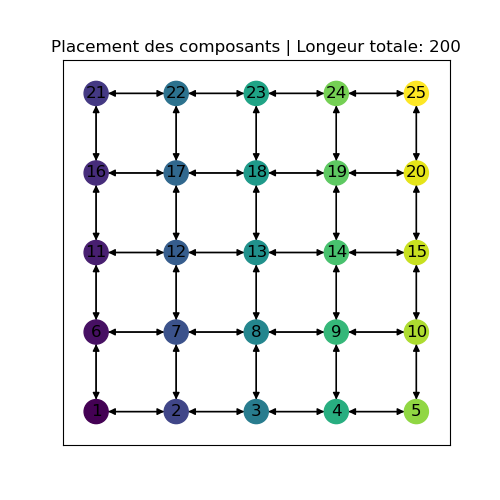

In [7]:
print_grid(composants_defaut, labels)

<IPython.core.display.Javascript object>


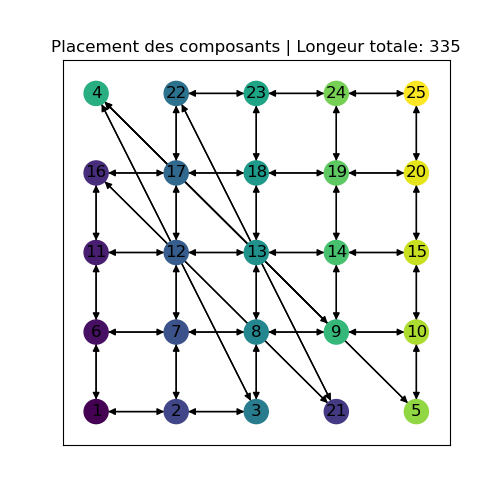

In [8]:
composants_new = element_permutation(composants_defaut.copy())
print_grid(composants_new, labels)

### 2. Recuit simule

In [9]:
def compute_delta_E(composants_1, composants_2):
    return compute_total_lenght(composants_2, 5, 5) - compute_total_lenght(composants_1, 5, 5)

In [10]:
def compute_initial_T(composants, t, start_lenght):
    # description: calcul de temperature initial
    
    # input: composants defaut, t: petite jolie tau
    # output: composants initials, T (les valeur pour demarrer recuit simule)
    
    composant_init = composants.copy()
    delta_E = 0
    
    # creer etat initial 
    while(compute_total_lenght(composant_init) <= start_lenght):
        composant_init = element_permutation(composant_init)
    
    
    
#     for i in range(50):
#         composant_init = element_permutation(composant_init)
            
    # calcul de delta_E moyen en faisant 100 essais
    for i in range(100):
        composants_temp = element_permutation(composant_init.copy())
        delta_E += compute_delta_E(composant_init, composants_temp)/100
    
    # calcul de T
    T = -(delta_E)/np.log(t)
    
    return composant_init, np.round(np.abs(T), 3)
# composants_init, T = compute_initial_T(composants_defaut, 0.95)
# print_grid(composants_init, labels)

In [11]:
def visualization(composants, list_E, T, fig, ax1, ax2):
    ax1.clear()
    ax1.plot([i for i in range(len(list_E))], list_E)
    ax1.set_title("Fonction cost")
    ax1.set_xlabel("#Iterations")
    ax1.set_ylabel("Cost(Longeur totale)")
    print_grid(composants, labels, ax2)
    fig.canvas.draw()

In [12]:
def recuit_simule(composants, t, c, start_lenght, T=None):
    # initialisation:
    if T is not None:
        composants_init, _ = compute_initial_T(composants, t, start_lenght)
    else:
        composants_init, T = compute_initial_T(composants, t, start_lenght)
    composants_optimal = composants_init.copy()
    
    print("Temperature au debut: ", T)
    print("Longeur au debut: ", compute_total_lenght(composants_optimal))
    
    # for display purpose
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    plt.ion()

    fig.show()
    fig.canvas.draw()
    
    # algoritm
    n_fige = 0
    list_E = [compute_total_lenght(composants_init, 5, 5)]
    
    visualization(composants_optimal, list_E, T, fig, ax1, ax2)
    
    n_iters = 0
    king = time.time()
    while(n_fige < 3 and T > 0):
        n_accepts = 0
        n_essais = 0
        n_iters += 1
        
        while(n_essais <= 2500):
            n_essais += 1
            kong = time.time()
            
            plt.suptitle("Temperature: {} | Temps: {}h:{}m:{}s \n #Iteration: {} | #Essais: {} | #Acceptations: {} | #NonAcceptations: {}"
                         .format(T, int((kong-king)//3600), int((kong-king)%3600//60), int((kong-king)%3600%60), n_iters, n_essais, n_accepts, n_essais-n_accepts))
            fig.canvas.draw()
            
            if(n_accepts <= 300):
                composants_temp = element_permutation(composants_optimal.copy())
                delta_E = compute_delta_E(composants_optimal, composants_temp)

                if(delta_E <= 0):
                    composants_optimal = composants_temp
                    n_accepts += 1
                else:
                    proba = np.round(random.uniform(0, 1), 3)
                    if (proba < np.round(np.exp(-delta_E/T), 3)):
                        composants_optimal = composants_temp
                        n_accepts += 1
            else:
                break
                
        list_E += [compute_total_lenght(composants_optimal, 5, 5)]
        visualization(composants_optimal, list_E, T, fig, ax1, ax2)
        
        if(list_E[-1]==list_E[-2]==list_E[-3]):
            n_fige += 1
            print("Xong roi nheeeeeeeeeeeee!")
        
        T = np.round(T*c, 3)
        
    return composants_init, composants_optimal, list_E

Temperature au debut:  45.262
Longeur au debut:  730


<IPython.core.display.Javascript object>


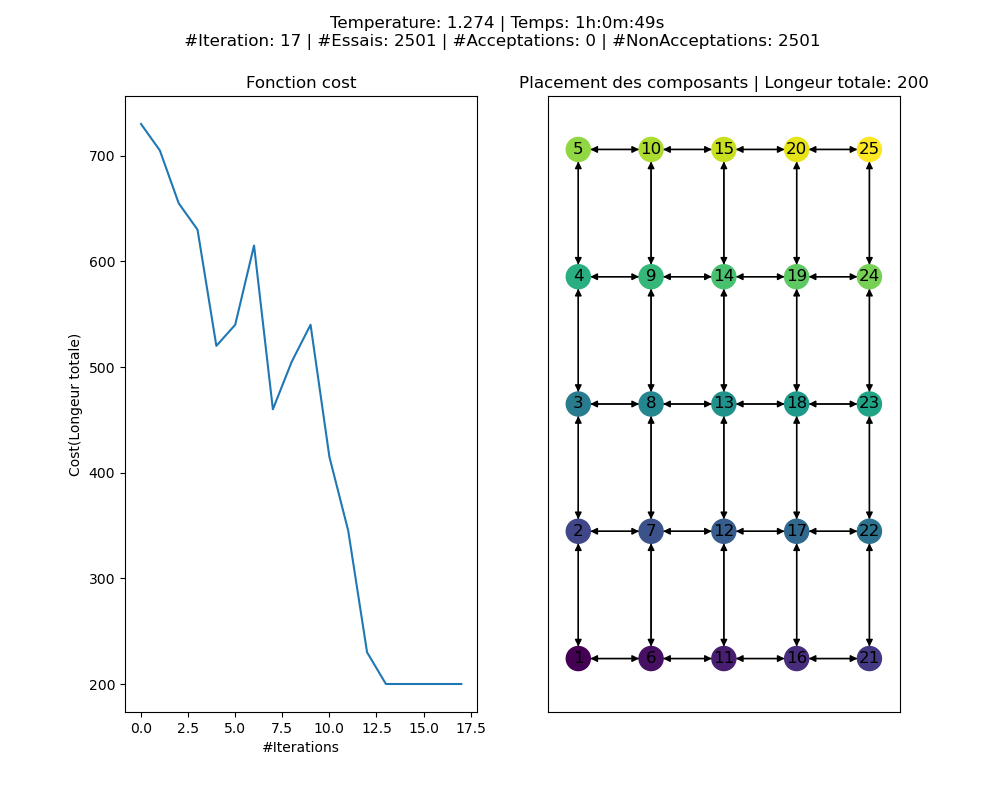

Xong roi nheeeeeeeeeeeee!
Xong roi nheeeeeeeeeeeee!
Xong roi nheeeeeeeeeeeee!


In [13]:
composants_init, composants_optimal, list_E = recuit_simule(composants_defaut, 0.8, 0.8, 700)